In [ ]:
# sipakmed1_path = kagglehub.dataset_download('soubhagyapaul/sipakmed1')

In [1]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
import torchvision
import os
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
print("bh")

 Generating images for: Dyskeratotic


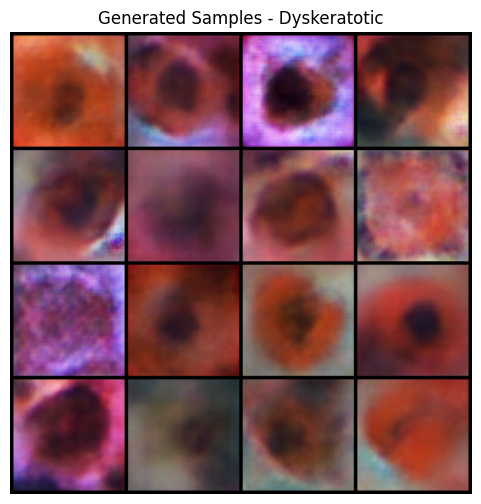

 Generating images for: Koilocytotic


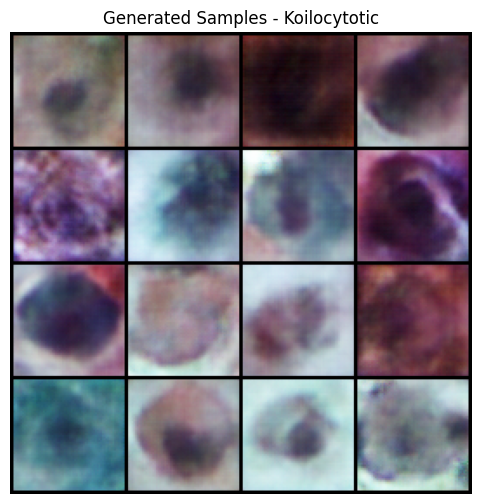

 Generating images for: Metaplastic


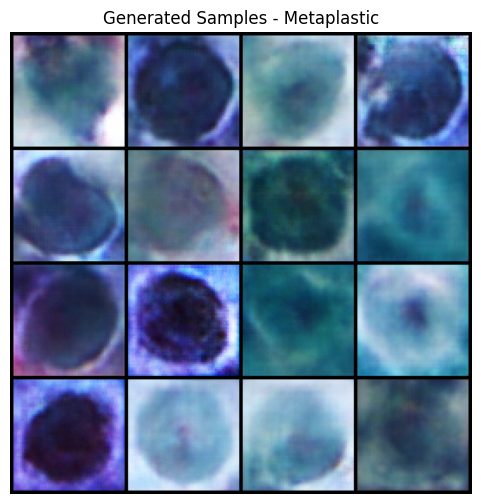

 Generating images for: Parabasal


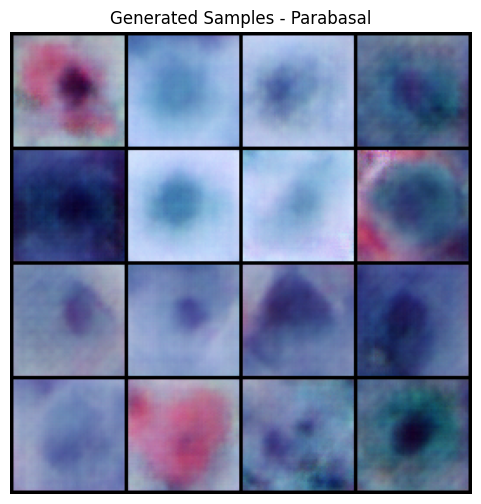

 Generating images for: Superficial-Intermediate


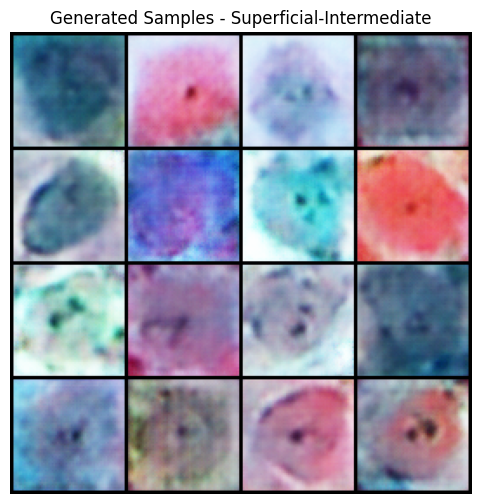

In [13]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
import torchvision
import os
import matplotlib.pyplot as plt

# ------------------------------
# Generator Definition
# ------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# ------------------------------
# Image Generation
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
num_images = 1000  # Total per class
batch_size = 25

class_names = [
    "Dyskeratotic",
    "Koilocytotic",
    "Metaplastic",
    "Parabasal",
    "Superficial-Intermediate"
]

output_dir = "/kaggle/working/generated_images"
os.makedirs(output_dir, exist_ok=True)

for class_name in class_names:
    print(f" Generating images for: {class_name}")
    save_path = os.path.join(output_dir, f"im_{class_name}")
    os.makedirs(save_path, exist_ok=True)
#/kaggle/input/wgangenerator/pytorch/default/1/fine_tuned_G_Dyskeratotic.pt
    # Load model
    generator = Generator().to(device)
    gen_path = f"/kaggle/input/wgangenerator/pytorch/default/1/fine_tuned_G_{class_name}.pt"
    generator.load_state_dict(torch.load(gen_path, map_location=device))
    generator.eval()

    with torch.no_grad():
        for i in range(0, num_images, batch_size):
            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake_images = generator(noise)

            for j in range(fake_images.size(0)):
                save_image(
                    fake_images[j].detach().cpu(),
                    os.path.join(save_path, f"{class_name}_{i + j + 1}.png"),
                    normalize=True
                )

            # Show first batch
            if i == 0:
                grid = torchvision.utils.make_grid(fake_images[:16].detach().cpu(), nrow=4, normalize=True)
                plt.figure(figsize=(6, 6))
                plt.imshow(grid.permute(1, 2, 0).numpy())
                plt.title(f"Generated Samples - {class_name}")
                plt.axis("off")
                plt.show()


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [3]:
import os
import shutil

# Real dataset root
real_base_path = "/kaggle/input/sipakmed1"
real_test_dataset_root = "/kaggle/working/real_test_dataset"

# Mapping of folders
class_names = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

# Create proper folder structure
os.makedirs(real_test_dataset_root, exist_ok=True)

for class_name in class_names:
    src_folder = os.path.join(real_base_path, f"im_{class_name}", f"im_{class_name}", "CROPPED")
    dst_folder = os.path.join(real_test_dataset_root, class_name)
    os.makedirs(dst_folder, exist_ok=True)

    # Copy all images from CROPPED to the new folder
    for file_name in os.listdir(src_folder):
        if file_name.endswith(".bmp"):
            shutil.copy(os.path.join(src_folder, file_name), os.path.join(dst_folder, file_name))

print(" All real class images copied for testing.")


 All real class images copied for testing.


In [32]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Set paths
synthetic_train_dir = "/kaggle/working/generated_images"
real_test_dir = "/kaggle/input/sipakmed1"

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=synthetic_train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(real_test_dir), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Synthetic Training Images: {len(train_dataset)}")
print(f"✅ Real Testing Images: {len(test_dataset)}")


✅ Synthetic Training Images: 25000
✅ Real Testing Images: 5015


In [16]:
import torch
from tqdm import tqdm
import torch.optim as optim
from torchvision import models
import torch.nn as nn  # Also ensure this is imported if not already

# Define optimizer and learning rate scheduler
#optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Optional: Cosine Annealing Scheduler (or use StepLR, etc.)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained ViT
model = models.vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, 5)  # 5 classes
model = model.to(device)

# Optimizer and Loss
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f" Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 200MB/s]  
Epoch 1/10: 100%|██████████| 782/782 [16:24<00:00,  1.26s/it]


 Epoch 1, Loss: 0.4390, Accuracy: 0.8340


Epoch 2/10: 100%|██████████| 782/782 [16:24<00:00,  1.26s/it]


 Epoch 2, Loss: 0.1774, Accuracy: 0.9371


Epoch 3/10: 100%|██████████| 782/782 [16:23<00:00,  1.26s/it]


 Epoch 3, Loss: 0.1141, Accuracy: 0.9598


Epoch 4/10: 100%|██████████| 782/782 [16:22<00:00,  1.26s/it]


 Epoch 4, Loss: 0.0928, Accuracy: 0.9676


Epoch 5/10: 100%|██████████| 782/782 [16:22<00:00,  1.26s/it]


 Epoch 5, Loss: 0.0676, Accuracy: 0.9761


Epoch 6/10: 100%|██████████| 782/782 [16:22<00:00,  1.26s/it]


 Epoch 6, Loss: 0.0506, Accuracy: 0.9829


Epoch 7/10: 100%|██████████| 782/782 [16:22<00:00,  1.26s/it]


 Epoch 7, Loss: 0.0322, Accuracy: 0.9886


Epoch 8/10: 100%|██████████| 782/782 [16:22<00:00,  1.26s/it]


 Epoch 8, Loss: 0.0199, Accuracy: 0.9931


Epoch 9/10: 100%|██████████| 782/782 [16:23<00:00,  1.26s/it]


 Epoch 9, Loss: 0.0086, Accuracy: 0.9969


Epoch 10/10: 100%|██████████| 782/782 [16:23<00:00,  1.26s/it]

 Epoch 10, Loss: 0.0033, Accuracy: 0.9992


In [21]:
!pip install seaborn scikit-learn pandas --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.9 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Metrics
print("📊 Classification Report on Real Test Set:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("🧾 Confusion Matrix (Test on Real Set)")
plt.show()


AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

📊 Classification Report on Real Test Set:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.95      0.70      0.81      1036
            im_Koilocytotic       0.77      0.71      0.74      1063
             im_Metaplastic       0.90      0.60      0.72      1064
               im_Parabasal       0.94      0.83      0.89       895
im_Superficial-Intermediate       0.53      0.97      0.68       957

                   accuracy                           0.76      5015
                  macro avg       0.82      0.76      0.77      5015
               weighted avg       0.82      0.76      0.76      5015



/tmp/ipykernel_35/2131397175.py:45: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


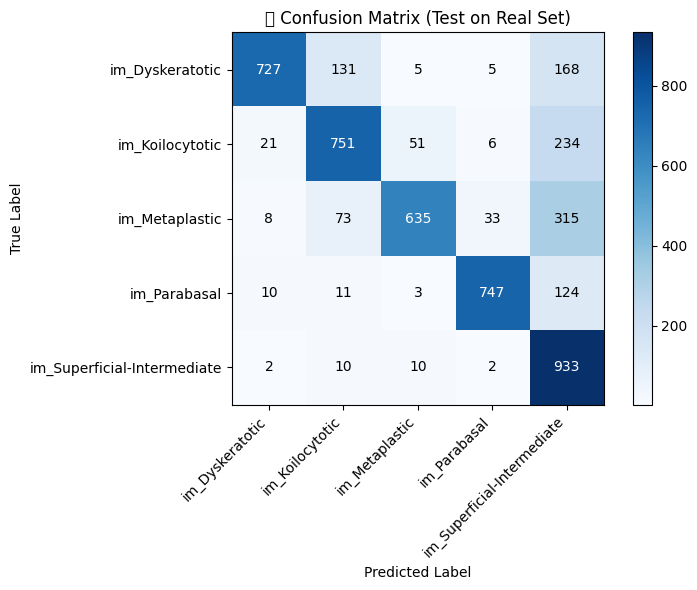

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Classification Report
print("📊 Classification Report on Real Test Set:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# ✅ Confusion Matrix using matplotlib only
cm = confusion_matrix(all_labels, all_preds)
classes = test_dataset.classes

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("🧾 Confusion Matrix (Test on Real Set)")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)

# Add numbers to cells
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


 Generating images for: Dyskeratotic


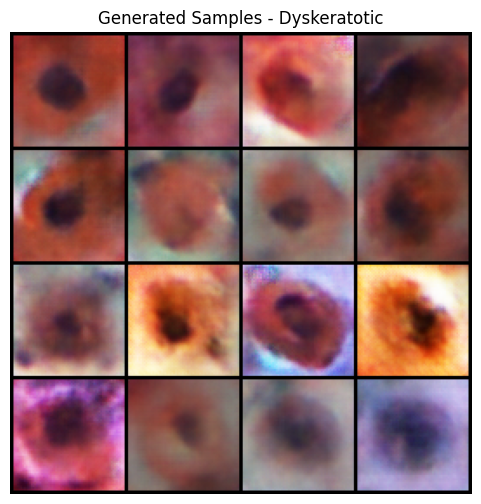

 Generating images for: Koilocytotic


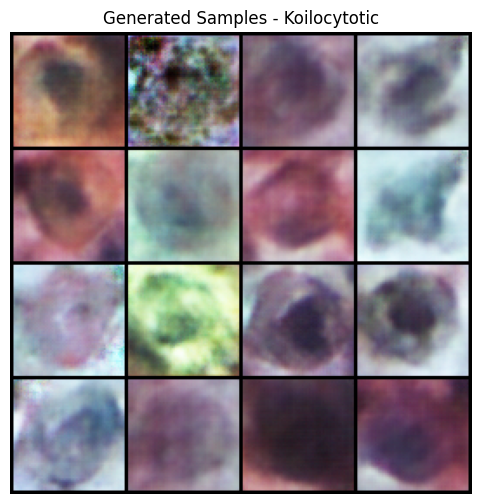

 Generating images for: Metaplastic


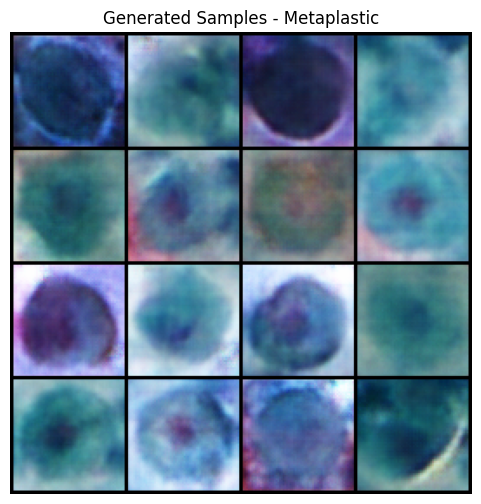

 Generating images for: Parabasal


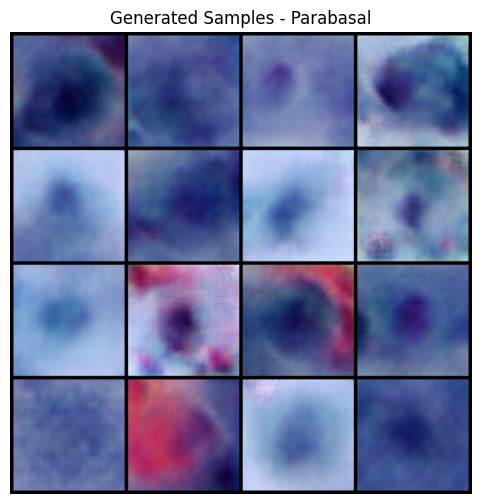

 Generating images for: Superficial-Intermediate


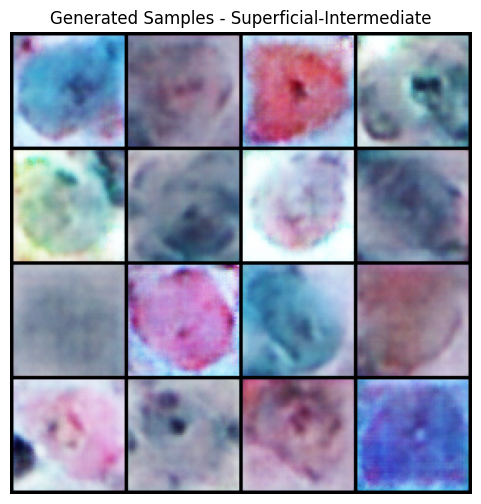

In [13]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
import torchvision
import os
import matplotlib.pyplot as plt

# ------------------------------
# Generator Definition
# ------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# ------------------------------
# Image Generation
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
num_images = 5000  # Total per class
batch_size = 25

class_names = [
    "Dyskeratotic",
    "Koilocytotic",
    "Metaplastic",
    "Parabasal",
    "Superficial-Intermediate"
]

output_dir = "/kaggle/working/generated_images"
os.makedirs(output_dir, exist_ok=True)

for class_name in class_names:
    print(f" Generating images for: {class_name}")
    save_path = os.path.join(output_dir, f"{class_name}")
    os.makedirs(save_path, exist_ok=True)
#/kaggle/input/wgangenerator/pytorch/default/1/fine_tuned_G_Dyskeratotic.pt
    # Load model
    generator = Generator().to(device)
    gen_path = f"/kaggle/input/wgangenerator/pytorch/default/1/fine_tuned_G_{class_name}.pt"
    generator.load_state_dict(torch.load(gen_path, map_location=device))
    generator.eval()

    with torch.no_grad():
        for i in range(0, num_images, batch_size):
            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake_images = generator(noise)

            for j in range(fake_images.size(0)):
                save_image(
                    fake_images[j].detach().cpu(),
                    os.path.join(save_path, f"{class_name}_{i + j + 1}.png"),
                    normalize=True
                )

            # Show first batch
            if i == 0:
                grid = torchvision.utils.make_grid(fake_images[:16].detach().cpu(), nrow=4, normalize=True)
                plt.figure(figsize=(6, 6))
                plt.imshow(grid.permute(1, 2, 0).numpy())
                plt.title(f"Generated Samples - {class_name}")
                plt.axis("off")
                plt.show()


In [8]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [9]:
real_data_dir = "/kaggle/working/real_test_dataset"  # organized by class
synthetic_data_dir = "/kaggle/working/generated_images"  # same structure by class

combined_temp_dir = "/kaggle/working/exp2_combined_dataset"  # will store train+test
os.makedirs(combined_temp_dir, exist_ok=True)


In [10]:
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import shutil

# Define temp dirs
train_real_dir = os.path.join(combined_temp_dir, "train_real")
test_real_dir = os.path.join(combined_temp_dir, "test_real")
os.makedirs(train_real_dir, exist_ok=True)
os.makedirs(test_real_dir, exist_ok=True)

# Step: collect all real image paths and class labels
real_dataset = ImageFolder(real_data_dir)
image_paths = [sample[0] for sample in real_dataset.samples]
labels = [sample[1] for sample in real_dataset.samples]
class_names = real_dataset.classes

# Stratified split (85-15 real split)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)

# Helper to copy images to new dirs
def copy_to_structure(paths, labels, dest_root):
    for img_path, label_idx in zip(paths, labels):
        class_name = class_names[label_idx]
        dest_dir = os.path.join(dest_root, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(dest_dir, os.path.basename(img_path)))

copy_to_structure(train_paths, train_labels, train_real_dir)
copy_to_structure(test_paths, test_labels, test_real_dir)


In [14]:
train_combined_dir = os.path.join(combined_temp_dir, "train")
test_final_dir = test_real_dir  # only untouched real images

os.makedirs(train_combined_dir, exist_ok=True)

# Copy real training images
copy_to_structure(train_paths, train_labels, train_combined_dir)

# Copy synthetic images
for class_name in class_names:
    src = os.path.join(synthetic_data_dir, class_name)
    dst = os.path.join(train_combined_dir, class_name)
    os.makedirs(dst, exist_ok=True)
    for file in os.listdir(src):
        shutil.copy(os.path.join(src, file), os.path.join(dst, file))


In [15]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(10, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

train_dataset = datasets.ImageFolder(train_combined_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_final_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [18]:
len(class_names)

5

In [19]:
from torchvision.models import vit_b_16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ViT
model = vit_b_16(weights="IMAGENET1K_V1")

# Get the input feature size of the classification head
in_features = model.heads[0].in_features

# Replace the classification head with one matching the number of classes
model.heads = nn.Sequential(
    nn.Linear(in_features, len(class_names))
)

model = model.to(device)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")


Epoch 1/10, Loss: 0.1116, Accuracy: 0.9641
Epoch 2/10, Loss: 0.0355, Accuracy: 0.9877
Epoch 3/10, Loss: 0.0263, Accuracy: 0.9911
Epoch 4/10, Loss: 0.0206, Accuracy: 0.9929
Epoch 5/10, Loss: 0.0184, Accuracy: 0.9935
Epoch 6/10, Loss: 0.0141, Accuracy: 0.9954
Epoch 7/10, Loss: 0.0128, Accuracy: 0.9957
Epoch 8/10, Loss: 0.0112, Accuracy: 0.9962
Epoch 9/10, Loss: 0.0100, Accuracy: 0.9967
Epoch 10/10, Loss: 0.0117, Accuracy: 0.9961


📊 Classification Report:
                          precision    recall  f1-score   support

            Dyskeratotic       0.99      0.96      0.97       122
            Koilocytotic       0.95      0.93      0.94       124
             Metaplastic       0.94      0.97      0.96       119
               Parabasal       0.99      1.00      1.00       118
Superficial-Intermediate       0.98      0.99      0.98       125

                accuracy                           0.97       608
               macro avg       0.97      0.97      0.97       608
            weighted avg       0.97      0.97      0.97       608



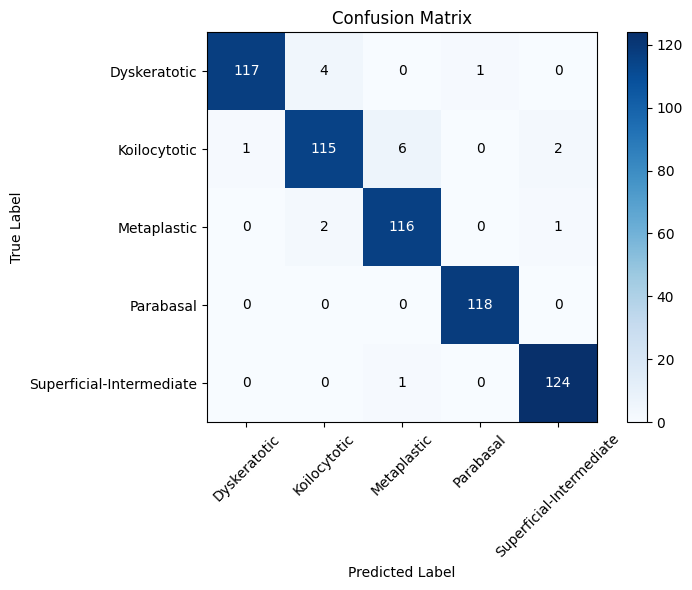

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Evaluate model
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotate each cell with its count
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [24]:
print("lb")

lb


In [4]:
import os
import random
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = "/kaggle/working/real_test_dataset"


In [5]:
split_path = "/kaggle/working/sipakmed_real_split"
train_dir = os.path.join(split_path, "train")
test_dir = os.path.join(split_path, "test")

if not os.path.exists(split_path):
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    for cls in class_dirs:
        cls_path = os.path.join(base_path, cls)
        images = os.listdir(cls_path)
        train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, cls))
        os.makedirs(os.path.join(test_dir, cls))

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
        for img in test_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))


In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes


In [7]:
from torchvision.models import vit_b_16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ViT
model = vit_b_16(weights="IMAGENET1K_V1")

# Get the input feature size of the classification head
in_features = model.heads[0].in_features

# Replace the classification head with one matching the number of classes
model.heads = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, len(class_names))
)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 173MB/s]  


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train_losses = []
train_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/10, Loss: 0.4996, Accuracy: 0.8180
Epoch 2/10, Loss: 0.1781, Accuracy: 0.9382
Epoch 3/10, Loss: 0.1173, Accuracy: 0.9598
Epoch 4/10, Loss: 0.0903, Accuracy: 0.9707
Epoch 5/10, Loss: 0.0775, Accuracy: 0.9728
Epoch 6/10, Loss: 0.0659, Accuracy: 0.9787
Epoch 7/10, Loss: 0.0920, Accuracy: 0.9700
Epoch 8/10, Loss: 0.0489, Accuracy: 0.9830
Epoch 9/10, Loss: 0.0353, Accuracy: 0.9895
Epoch 10/10, Loss: 0.0307, Accuracy: 0.9920


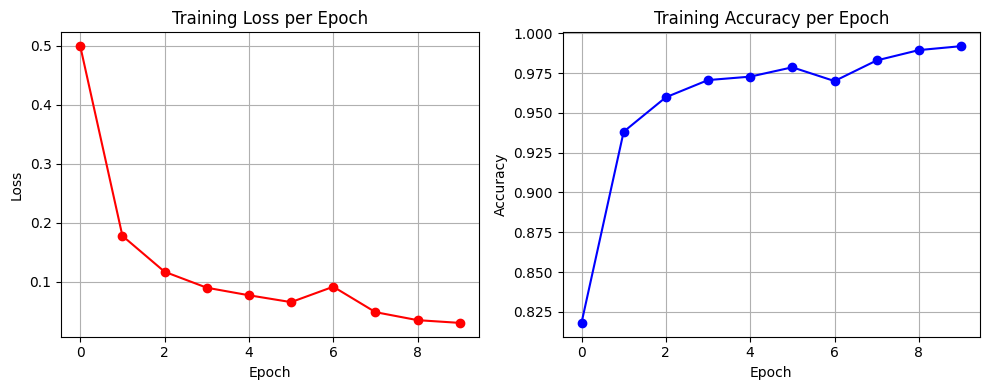

In [9]:
# Plot curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o', color='red')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, marker='o', color='blue')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()





📊 Classification Report:
                          precision    recall  f1-score   support

            Dyskeratotic       1.00      0.91      0.95       163
            Koilocytotic       0.90      0.94      0.92       165
             Metaplastic       0.95      0.96      0.96       159
               Parabasal       0.98      0.99      0.99       158
Superficial-Intermediate       0.98      1.00      0.99       167

                accuracy                           0.96       812
               macro avg       0.96      0.96      0.96       812
            weighted avg       0.96      0.96      0.96       812



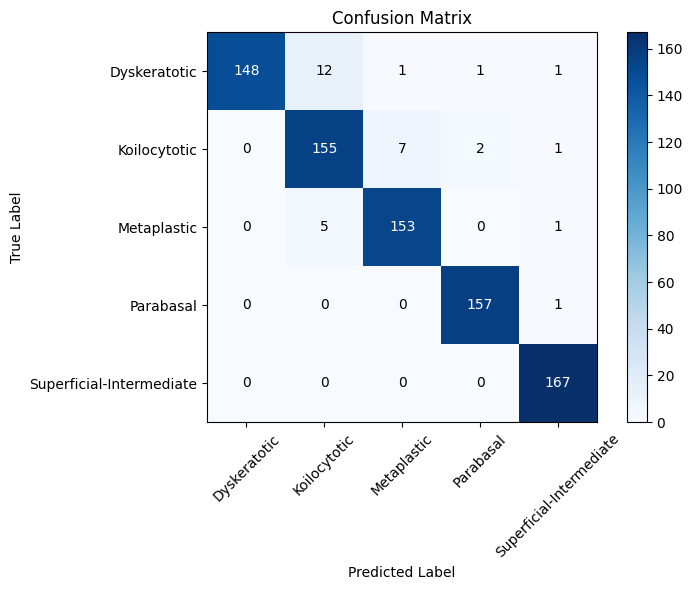

In [10]:
# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Annotate values
thresh = cm.max() / 2
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [11]:
g_losses = [
    3.7232, 2.0110, 1.1251, 2.3846, 3.3695, 2.3854, 0.2197, -1.3605, -1.0246, -1.1512,
    -0.2133, -0.2342, -0.7252, -1.2493, -0.6066, -0.9849, -0.9532, -0.7725, -0.3781,
    -0.4145, -0.3448, -0.9326, -0.6806, -0.7041, -0.9285
]

d_losses = [
    585.0975, 56.3898, 2.6475, -1.5584, -3.1891, -4.4359, -2.3622, -2.2264, -2.2189, -2.5298,
    -2.7795, -2.9898, -2.1572, -3.3422, -2.8640, -2.9159, -2.9884, -4.1838, -3.3846,
    -4.0255, -4.0128, -3.6245, -3.7343, -4.1464, -4.0441
]



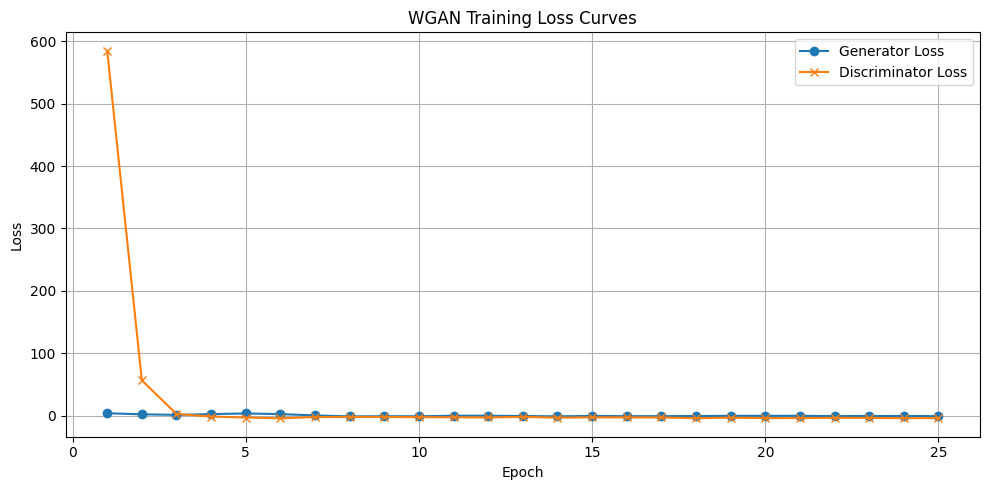

In [12]:
import matplotlib.pyplot as plt

epochs = list(range(1, 26))

plt.figure(figsize=(10, 5))
plt.plot(epochs, g_losses, label="Generator Loss", marker='o')
plt.plot(epochs, d_losses, label="Discriminator Loss", marker='x')
plt.title("WGAN Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from scipy.linalg import sqrtm
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transform
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Load limited number of images from folder
def load_images(path, max_images=100):
    images = []
    for root, _, files in os.walk(path):
        for file in sorted(files):
            if file.endswith((".jpg", ".png", ".jpeg", "bmp")):
                image = Image.open(os.path.join(root, file)).convert("RGB")
                images.append(transform(image))
                if len(images) >= max_images:
                    break
        if len(images) >= max_images:
            break
    return torch.stack(images)

# Load datasets
real_path = "/kaggle/working/real_test_dataset"
fake_path = "/kaggle/working/generated_images"
real_images = load_images(real_path)
fake_images = load_images(fake_path)

# Load InceptionV3
inception = inception_v3(pretrained=True, transform_input=False).to(device)
inception.fc = torch.nn.Identity()
inception.eval()

# Get features
def get_features(images, model, batch_size=16):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size].to(device)
        with torch.no_grad():
            pred = model(batch)
        features.append(pred.cpu().numpy())
    return np.concatenate(features, axis=0)

# Extract features
real_feats = get_features(real_images, inception)
fake_feats = get_features(fake_images, inception)

# FID calculation
def calculate_fid(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)

mu1, sigma1 = real_feats.mean(axis=0), np.cov(real_feats, rowvar=False)
mu2, sigma2 = fake_feats.mean(axis=0), np.cov(fake_feats, rowvar=False)
fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)

# Inception Score
inception.fc = torch.nn.Linear(2048, 1000).to(device)
inception.eval()
def calculate_inception_score(images, model, splits=10):
    preds = []
    for i in range(0, len(images), 16):
        batch = images[i:i+16].to(device)
        with torch.no_grad():
            pred = model(batch)
            preds.append(torch.nn.functional.softmax(pred, dim=1).cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    scores = []
    split_size = preds.shape[0] // splits
    for i in range(splits):
        part = preds[i * split_size:(i + 1) * split_size]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.sum(part * (np.log(part) - np.log(py + 1e-6)), axis=1).mean()))
    return np.mean(scores), np.std(scores)

inception_score, inception_std = calculate_inception_score(fake_images, inception)

print(f"FID Score: {fid_score:.2f}")
print(f"Inception Score: {inception_score:.2f} ± {inception_std:.2f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 188MB/s]  


FID Score: 229.72
Inception Score: 1.01 ± 0.00


In [20]:
import os
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models.inception import inception_v3
import torch
import torch.nn.functional as F
from scipy import linalg
import numpy as np
from PIL import Image
import torchvision.models as models
from torchvision.models import Inception_V3_Weights
# -----------------------------
# Function to calculate FID score
# -----------------------------
def get_activations(dataloader, model, device):
    model.eval()
    act = []
    with torch.no_grad():
        for batch, _ in dataloader:
            batch = batch.to(device)
            pred = model(batch)[0]
            act.append(pred.cpu().numpy())
    return np.concatenate(act, axis=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# -----------------------------
# Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

weights = Inception_V3_Weights.DEFAULT  # pretrained weights and transforms
inception = models.inception_v3(weights=weights)
inception.fc = torch.nn.Identity()  # remove final classifier layer
inception.eval()
inception.to(device)
# -----------------------------
# Class list (adjust as needed)
# -----------------------------
classes = ["im_Parabasal", "im_Koilocytotic", "im_Dyskeratotic", "im_Superficial-Intermediate", "im_Metaplastic"]

real_root = "/kaggle/working/real_test_dataset"
fake_root = "/kaggle/working/generated_images"

# -----------------------------
# Compute FID for each class
# -----------------------------
fid_scores = {}

for class_name in tqdm(classes):
    real_path = os.path.join(real_root, class_name)
    fake_path = os.path.join(fake_root, class_name)

    if not os.path.exists(real_path) or not os.path.exists(fake_path):
        print(f"Skipping {class_name} — folder not found.")
        continue

    real_data = ImageFolder(root=real_path, transform=transform)
    fake_data = ImageFolder(root=fake_path, transform=transform)

    real_loader = DataLoader(real_data, batch_size=32, shuffle=False, num_workers=2)
    fake_loader = DataLoader(fake_data, batch_size=32, shuffle=False, num_workers=2)

    real_act = get_activations(real_loader, inception, device)
    fake_act = get_activations(fake_loader, inception, device)

    fid = calculate_fid(real_act, fake_act)
    fid_scores[class_name] = fid

# -----------------------------
# Print results
# -----------------------------
print("\n📊 Per-Class FID Scores:\n")
for cls, score in fid_scores.items():
    print(f"{cls}: {score:.2f}")


100%|██████████| 5/5 [00:00<00:00, 9169.88it/s]

Skipping im_Parabasal — folder not found.
Skipping im_Koilocytotic — folder not found.
Skipping im_Dyskeratotic — folder not found.
Skipping im_Superficial-Intermediate — folder not found.
Skipping im_Metaplastic — folder not found.

📊 Per-Class FID Scores:



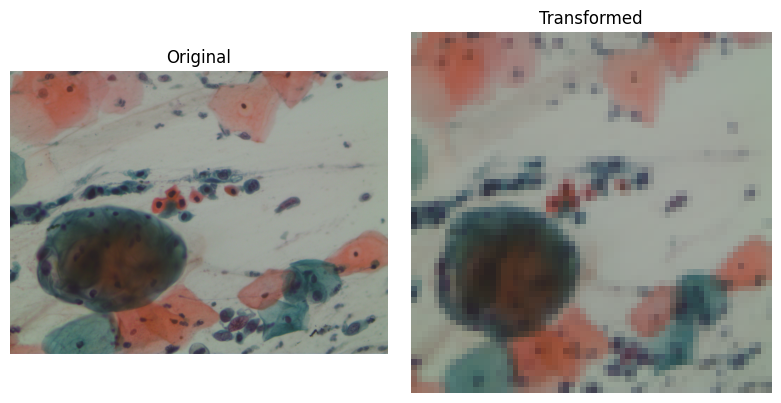

In [11]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Load sample image
image_path = "/kaggle/input/sipakmed1/im_Dyskeratotic/im_Dyskeratotic/001.bmp"
img = Image.open(image_path).convert("RGB")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Apply transformation
img_transformed = transform(img)

# Convert back to displayable format (unnormalize)
img_display = img_transformed * 0.5 + 0.5  # unnormalize to [0, 1]
img_display = img_display.permute(1, 2, 0).numpy()  # CHW to HWC

# Show before and after
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_display)
plt.title("Transformed")
plt.axis("off")
plt.tight_layout()
plt.show()
